<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/NormalizationV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import random
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from skimage import exposure
from tqdm import tqdm

In [2]:
!rm -r sample_data/
!rm -r montgomery/
!rm -r china/

!mkdir montgomery
!mkdir china

rm: cannot remove 'montgomery/': No such file or directory
rm: cannot remove 'china/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
def showImagesHorizontally(images_shown, image_directory, title):

    list_of_files = sorted(os.listdir(image_directory))
    if 'Thumbs.db' in list_of_files:
      list_of_files.remove('Thumbs.db')

    fig = plt.figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)

    loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

    for i in range(loop_range):
      a=fig.add_subplot(1,images_shown,i+1)
      image_path = image_directory + list_of_files[i]
      filename, file_extension = os.path.splitext(image_path)

      if file_extension == '.tiff':
        image = tiff.imread(image_path) 
        image = np.clip(image, 0, 1)
        
      else:
        image = imread(image_path)

      plt.imshow(image,cmap='Greys_r') 
      plt.axis('off')

In [5]:
def showImageHistograms(images_shown, image_directory, title):

  list_of_files = sorted(os.listdir(image_directory))
  loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

  fig = plt.figure(figsize=(20,3))
  fig.suptitle(title,y=1)

  for i in range(loop_range):

    plt.subplot(1,loop_range,i+1)
    img = cv2.imread(image_directory + list_of_files[i])
    vals = img.mean(axis=2).flatten()
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
    plt.ylim([0,20000])

  plt.show()

In [6]:
def crop_background(image_directory, save_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      image_size = (1024,1024)
      final_crop = cv2.resize(crop, dsize=image_size, interpolation=cv2.INTER_CUBIC)
      if save_directory is None:
        if 'CHNCXR' in list_of_files[i]:
          cv2.imwrite('/content/china/' + list_of_files[i], final_crop)
        else:
          cv2.imwrite('/content/montgomery/' + list_of_files[i], final_crop)
      else:
          cv2.imwrite(save_directory + list_of_files[i], final_crop)
        

In [7]:
# Comparing histograms

def histogram_comparison(path_1, path_2, method, isTest):

  image_list_1 = os.listdir(path_1)
  image_list_2 = os.listdir(path_2)

  histogram_values = []

  random_index_list = random.sample(range(0, 99), 25) if isTest is False else [0,1,2,3,4]

  for i in tqdm(range(len(image_list_1))):

    current_reference_image = cv2.imread(path_1 + image_list_1[i])
    current_hist = cv2.calcHist([current_reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    current_hist = cv2.normalize(current_hist, current_hist).flatten()

    for j in random_index_list:
      current_comparison_image = cv2.imread(path_2 + image_list_2[j])
      reference_hist = cv2.calcHist([current_comparison_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
      reference_hist = cv2.normalize(reference_hist, reference_hist).flatten()

      hist_comparison = cv2.compareHist(current_hist, reference_hist, method)
      histogram_values.append(hist_comparison)

  return histogram_values


In [8]:
drive_directory = '/content/drive/MyDrive/SYDE 677 Final Project/CXR_png/'
crop_background(drive_directory, None, False)

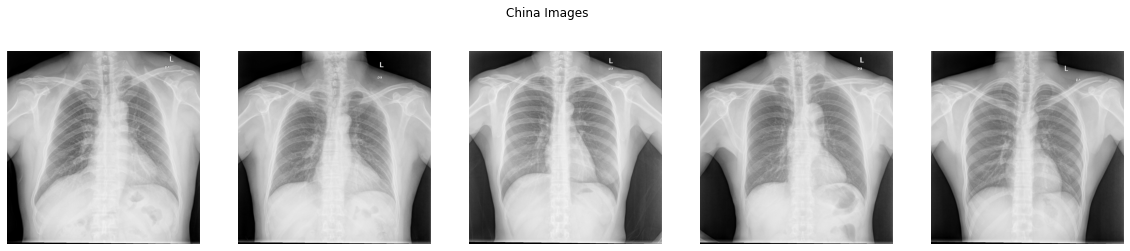

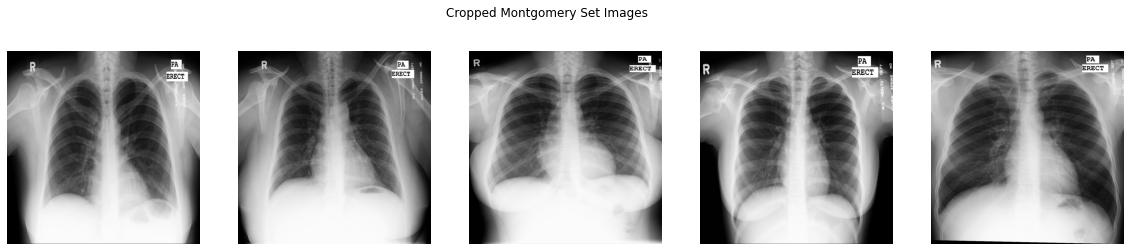

In [9]:
showImagesHorizontally(5,'/content/china/', 'China Images')
showImagesHorizontally(5, '/content/montgomery/', 'Cropped Montgomery Set Images')

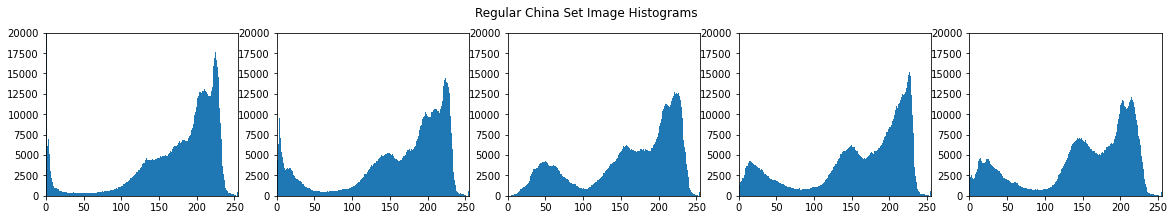

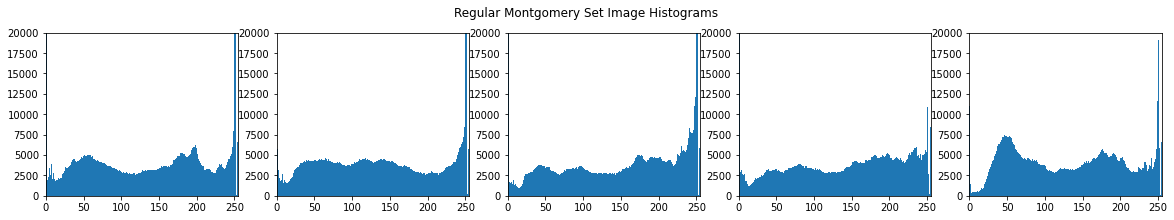

In [10]:
showImageHistograms(5, '/content/china/', 'Regular China Set Image Histograms')
showImageHistograms(5, '/content/montgomery/', 'Regular Montgomery Set Image Histograms')

In [11]:
def normalization(image_path,save_path,isTest):
  list_of_files = os.listdir(image_path)

  loop_range = 5 if isTest else len(list_of_files)

  for i in tqdm(range(loop_range)):

    img = cv2.imread(image_path + list_of_files[i])
    img = exposure.equalize_adapthist(img/np.max(img))
    img = exposure.rescale_intensity(img, out_range=(0, 255))


    cv2.imwrite(save_path + list_of_files[i], img)


In [12]:
!rm -r normalize_test_china/
!rm -r normalize_test_montgomery/

!mkdir normalize_test_china
!mkdir normalize_test_montgomery

rm: cannot remove 'normalize_test_china/': No such file or directory
rm: cannot remove 'normalize_test_montgomery/': No such file or directory


In [13]:
normalization("/content/china/","/content/normalize_test_china/", False)
normalization("/content/montgomery/","/content/normalize_test_montgomery/", False)

100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


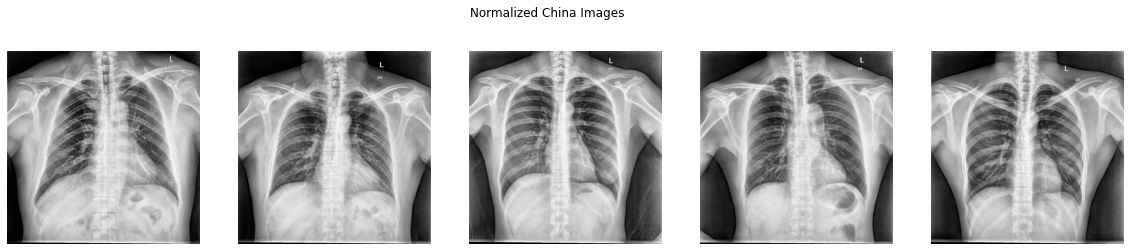

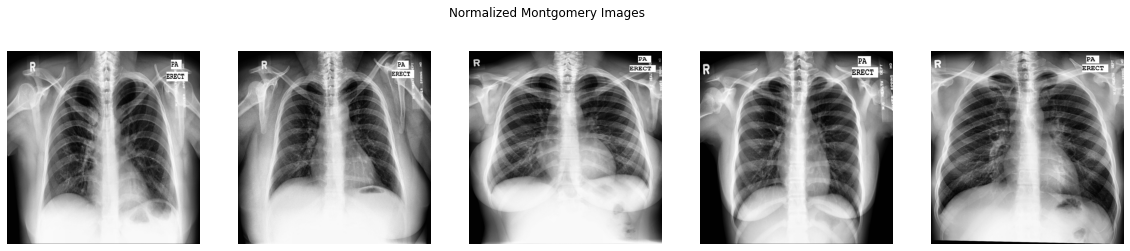

In [14]:
showImagesHorizontally(5,'/content/normalize_test_china/', 'Normalized China Images')
showImagesHorizontally(5,'/content/normalize_test_montgomery/', 'Normalized Montgomery Images')

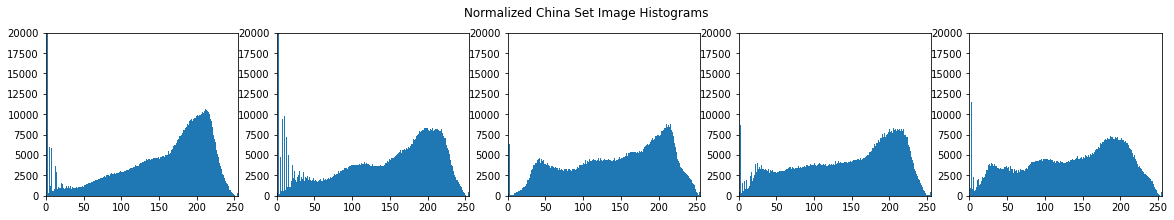

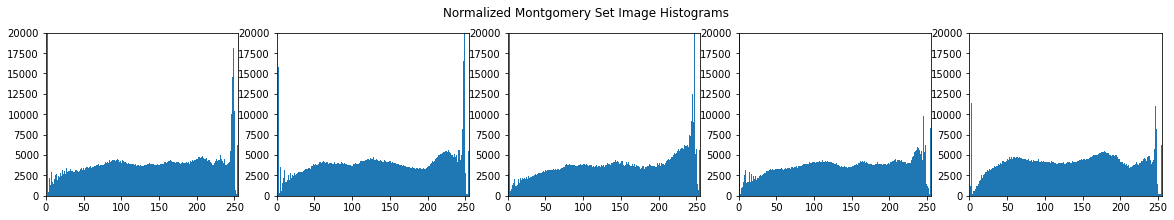

In [15]:
showImageHistograms(5, '/content/normalize_test_china/', 'Normalized China Set Image Histograms')
showImageHistograms(5, '/content/normalize_test_montgomery/', 'Normalized Montgomery Set Image Histograms')

In [16]:
OPENCV_METHODS = (
	("Correlation", cv2.HISTCMP_CORREL), # larger value = more similarity
	("Chi-Squared", cv2.HISTCMP_CHISQR), # smaller value = more similarity
	("Intersection", cv2.HISTCMP_INTERSECT), # larger value = more similarity
	("Hellinger", cv2.HISTCMP_BHATTACHARYYA)) # smaller value = more similarity

In [17]:
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/montgomery/', '/content/china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Correlation 0.7765123905758556 0.0763771572846787


100%|██████████| 138/138 [01:45<00:00,  1.31it/s]


Chi-Squared 1.3705055471687573 0.6817211685023767


100%|██████████| 138/138 [01:42<00:00,  1.35it/s]


Intersection 1.7564680512702984 0.18734671594919605


100%|██████████| 138/138 [01:44<00:00,  1.31it/s]

Hellinger 0.2620943611482976 0.04588439417077477


In [18]:
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/normalize_test_montgomery/', '/content/normalize_test_china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

100%|██████████| 138/138 [01:47<00:00,  1.29it/s]


Correlation 0.8773740059752279 0.06546330533934773


100%|██████████| 138/138 [01:53<00:00,  1.21it/s]


Chi-Squared 0.5655968600318518 0.32074493424661554


100%|██████████| 138/138 [01:47<00:00,  1.29it/s]


Intersection 2.1261606363174708 0.19904413023360387


100%|██████████| 138/138 [01:47<00:00,  1.28it/s]

Hellinger 0.18814085641302597 0.04970012802727349


In [19]:
!rm -r set_1/
!rm -r set_2/
!rm -r set_3/

!mkdir set_1
!mkdir set_2
!mkdir set_3

rm: cannot remove 'set_1/': No such file or directory
rm: cannot remove 'set_2/': No such file or directory
rm: cannot remove 'set_3/': No such file or directory


In [20]:
set_1_path = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_1/'
set_2_path = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_2/'
set_3_path = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_3/'

crop_background(set_1_path, '/content/set_1/', False)
crop_background(set_2_path, '/content/set_2/', False)
crop_background(set_3_path, '/content/set_3/', False)

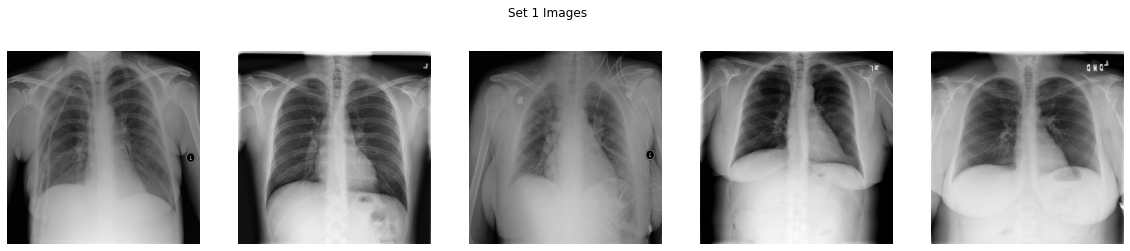

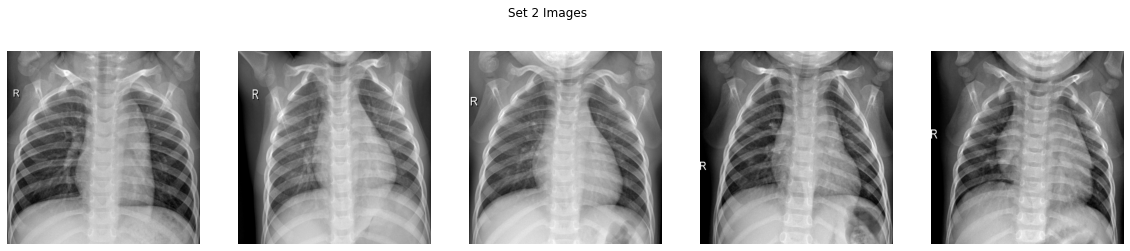

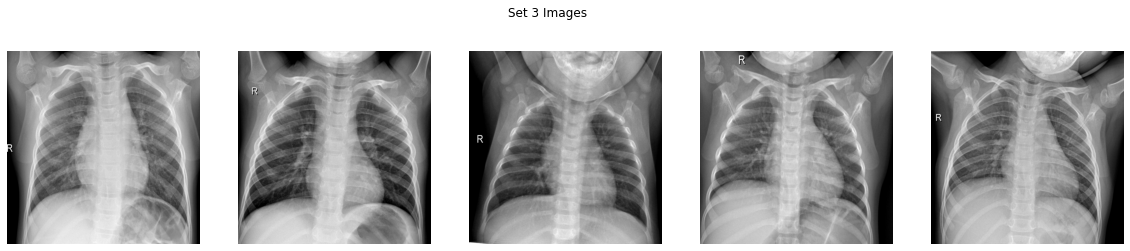

In [21]:
showImagesHorizontally(5, '/content/set_1/', 'Set 1 Images')
showImagesHorizontally(5, '/content/set_2/', 'Set 2 Images')
showImagesHorizontally(5, '/content/set_3/', 'Set 3 Images')

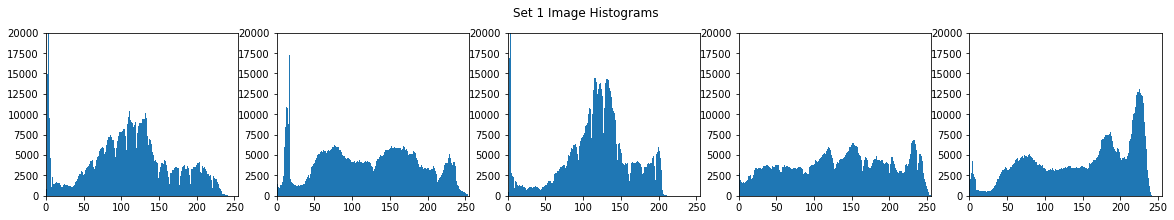

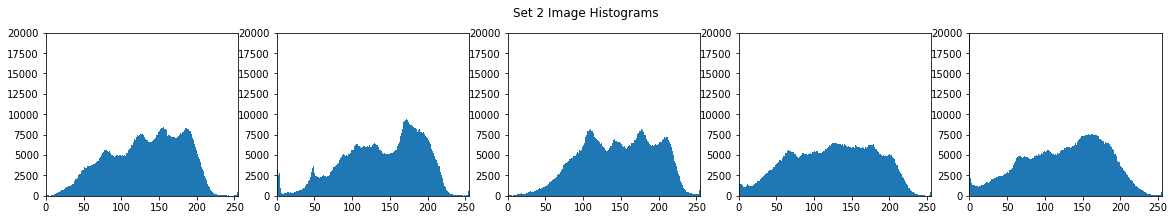

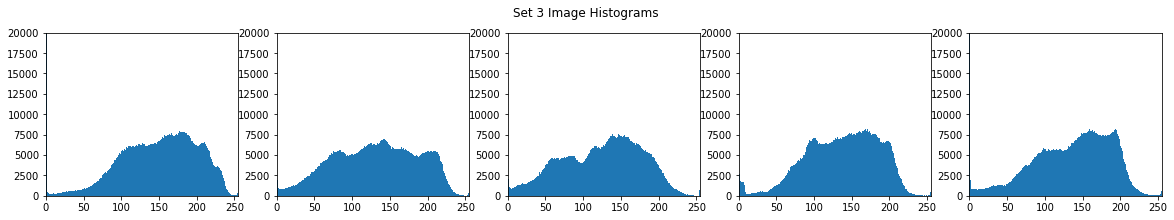

In [22]:
showImageHistograms(5, '/content/set_1/', 'Set 1 Image Histograms')
showImageHistograms(5, '/content/set_2/', 'Set 2 Image Histograms')
showImageHistograms(5, '/content/set_3/', 'Set 3 Image Histograms')

In [24]:
print('Set 1 Original')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_1/', '/content/china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 1 Original


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Correlation 0.8093916608970987 0.10936222278464706


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Chi-Squared 104.2102569535472 675.2344280813169


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Intersection 1.7365532256966318 0.284967750898001


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

Hellinger 0.2804465380423785 0.09502285992956612


In [26]:
print('Set 2 Original')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_2/', '/content/china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 2 Original


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Correlation 0.7788973185952129 0.10223771624117814


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Chi-Squared 12.956402219860754 21.726515979218572


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Intersection 1.5198524985955097 0.26394860328258046


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

Hellinger 0.28865416373950054 0.07873536276879295


In [27]:
print('Set 3 Original')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_1/', '/content/china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 3 Original


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Correlation 0.7860800267813992 0.1261668569921032


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Chi-Squared 121.45137629890363 946.9009996045145


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Intersection 1.6742256645751978 0.26190753899150865


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Hellinger 0.2746082654405703 0.08784728483307938


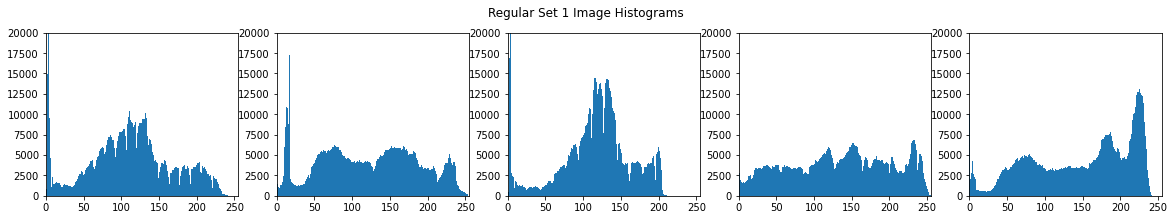

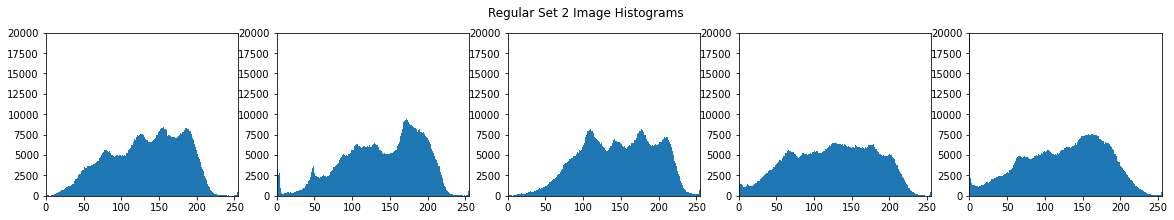

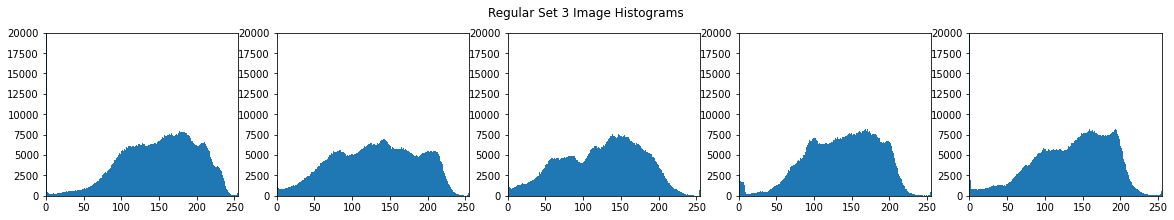

In [28]:
showImageHistograms(5, '/content/set_1/', 'Regular Set 1 Image Histograms')
showImageHistograms(5, '/content/set_2/', 'Regular Set 2 Image Histograms')
showImageHistograms(5, '/content/set_3/', 'Regular Set 3 Image Histograms')

In [29]:
normalization('/content/set_1/','/content/set_1/', False)
normalization('/content/set_2/','/content/set_2/', False)
normalization('/content/set_3/','/content/set_3/', False)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


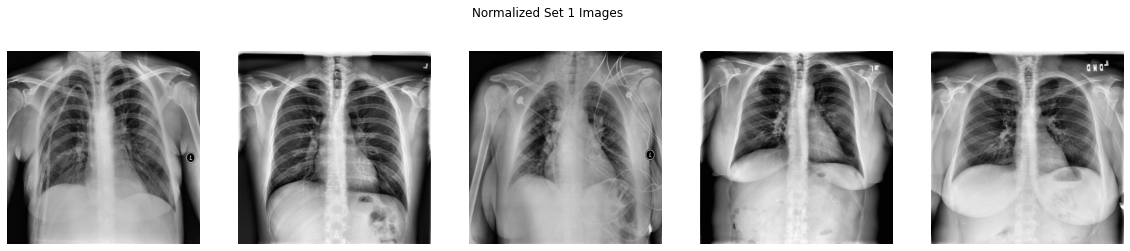

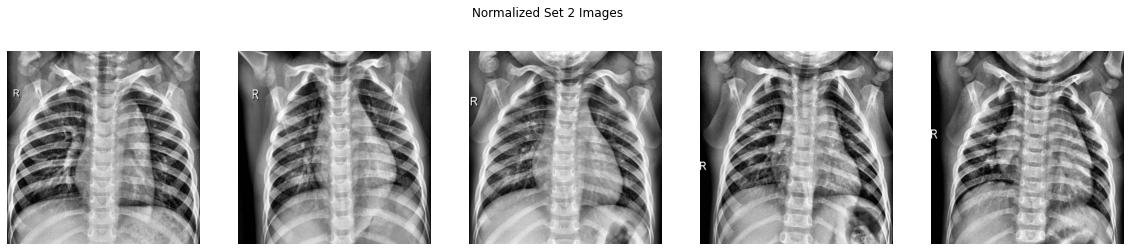

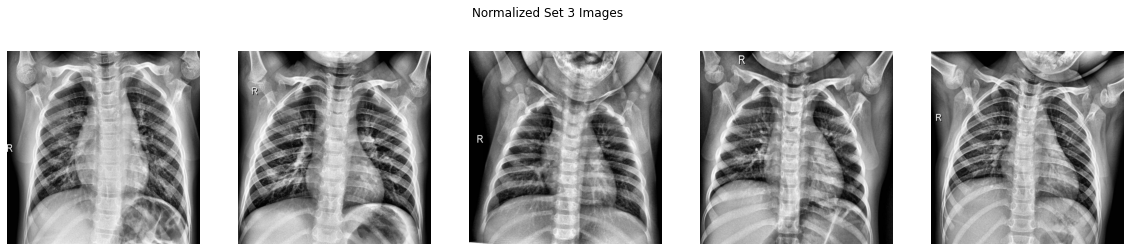

In [30]:
showImagesHorizontally(5, '/content/set_1/', 'Normalized Set 1 Images')
showImagesHorizontally(5, '/content/set_2/', 'Normalized Set 2 Images')
showImagesHorizontally(5, '/content/set_3/', 'Normalized Set 3 Images')

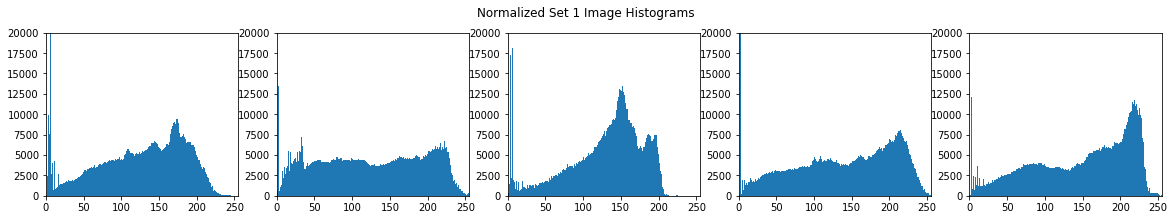

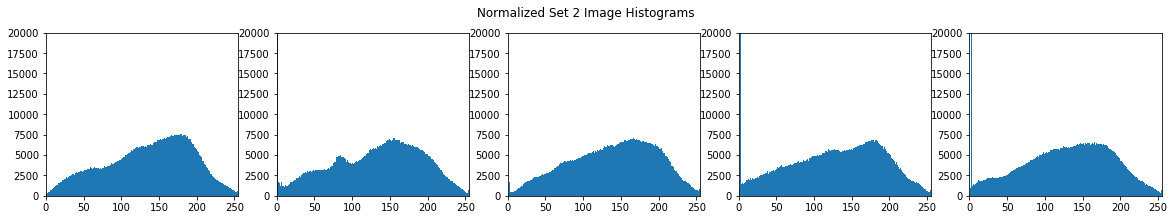

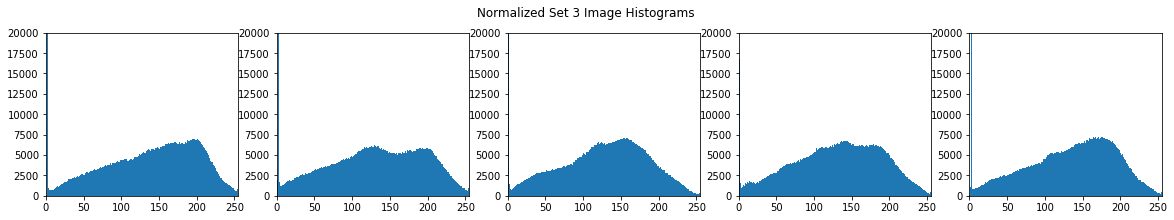

In [31]:
showImageHistograms(5, '/content/set_1/', 'Normalized Set 1 Image Histograms')
showImageHistograms(5, '/content/set_2/', 'Normalized Set 2 Image Histograms')
showImageHistograms(5, '/content/set_3/', 'Normalized Set 3 Image Histograms')

In [32]:
print('Set 1 Normalized')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_1/', '/content/normalize_test_china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 1 Normalized


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Correlation 0.9277336501742327 0.05962660286293591


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Chi-Squared 3.147740918137653 10.907598786865448


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Intersection 2.1513010988416617 0.24176671775992353


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]

Hellinger 0.1530143299868484 0.0676196166626225


In [33]:
print('Set 2 Normalized')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_2/', '/content/normalize_test_china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 2 Normalized


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Correlation 0.8946892666584106 0.051843003354305375


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Chi-Squared 0.7298128735638646 0.4876864894230948


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Intersection 2.1401810762286186 0.17242535532757108


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Hellinger 0.1518752634699481 0.04381064324062329


In [34]:
print('Set 3 Normalized')
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/set_3/', '/content/normalize_test_china/', method, False)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Set 3 Normalized


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Correlation 0.9245057944354532 0.046293289394330896


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Chi-Squared 0.5698556424216942 0.44305203298012347


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Intersection 2.1853091557219626 0.15017288707471535


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Hellinger 0.15013887205777282 0.046723779129395626
